In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    if path:
        raise Exception('changed')
except:
    path = True
    sys.path.append('../')

from math import log, ceil
from tqdm.notebook import tqdm
from src.god_model_generator import god_model_sample
from src.god_model_estimator import estimate_mu_pi
from src.bos_model_estimator import univariate_em, observation_likelihood, _probability_x_given_mu_pi, estimate_mu_pi as estimate_mu_pi_bos, probability_x_given_mu_pi_scratch as aux_probability_x_given_mu_pi, compute_polynomials
from src.data_generator import bos_model
from src.compute_u import compute_u
from model_tools import evaluate_polynomial, group_sum
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.interpolate import lagrange
from time import perf_counter

In [3]:
from src.bos_model_polynomials import compute_polynomials as compute_polynomials_v2, compute_polynomials_v3, compute_polynomials_v4

In [4]:
_ = compute_polynomials_v2(5), compute_polynomials_v3(5), compute_polynomials_v4(5)

In [5]:
%%timeit
_ = compute_polynomials_v2(10)

3.78 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit
_ = compute_polynomials_v3(10)

5.95 ms ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
_ = compute_polynomials_v4(100)

5.34 s ± 190 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
def benchmark_f(f, m_max: int, sample: int=10):
    times = []
    for m in tqdm(range(m_max, 0, -1)):
        t = perf_counter()
        for _ in range(sample):
            _ = f(m)
        times.append((perf_counter() - t) / sample)
    times.reverse()
    return times

In [94]:
m_max = 25
sample = 4
alpha = 4.053e-05
k = 4.25
predicted_time = alpha * m_max ** k
total_predicted_time = alpha * m_max ** (k + 1) / (k + 1)
print(f'predicted time: {sample * predicted_time:.2f} seconds, {sample * predicted_time / 60:.2f} minutes')
print(f'total predicted time: {sample * total_predicted_time:.2f} seconds, {sample * total_predicted_time / 60:.2f} minutes')
bench_v1 = np.array(benchmark_f(compute_polynomials, m_max, sample=sample))
print(f"{bench_v1[-1]: .2f} seconds")

predicted time: 141.61 seconds, 2.36 minutes
total predicted time: 832.98 seconds, 13.88 minutes


  0%|          | 0/25 [00:00<?, ?it/s]

 30.31 seconds


In [105]:
m_max = 50
sample = 10
alpha = 7.742e-07
k = 3.75
predicted_time = alpha * m_max ** k
total_predicted_time = alpha * m_max ** (k + 1) / (k + 1)
print(f'predicted time: {sample * predicted_time:.2f} seconds, {sample * predicted_time / 60:.2f} minutes')
print(f'total predicted time: {sample * total_predicted_time:.2f} seconds, {sample * total_predicted_time / 60:.2f} minutes')
bench_v2 = np.array(benchmark_f(compute_polynomials_v2, m_max, sample=sample))
print(f"{bench_v2[-1]: .2f} seconds")

predicted time: 33.33 seconds, 0.56 minutes
total predicted time: 444.38 seconds, 7.41 minutes


  0%|          | 0/50 [00:00<?, ?it/s]

 1.51 seconds


In [27]:
m_max = 100
sample = 10
alpha = 1.797e-08
k = 4
predicted_time = alpha * m_max ** k
total_predicted_time = alpha * m_max ** (k + 1) / (k + 1)
print(f'predicted time: {sample * predicted_time:.2f} seconds, {sample * predicted_time / 60:.2f} minutes')
print(f'total predicted time: {sample * total_predicted_time:.2f} seconds, {sample * total_predicted_time / 60:.2f} minutes')
bench_v3 = np.array(benchmark_f(compute_polynomials_v4, m_max, sample=sample))
print(f"{bench_v3[-1]: .2f} seconds")

predicted time: 17.97 seconds, 0.30 minutes
total predicted time: 359.40 seconds, 5.99 minutes


  0%|          | 0/100 [00:00<?, ?it/s]

 5.25 seconds


In [11]:
alpha = 7.536e-08
k = 3.75
(5 / alpha) ** (1 / k)

121.84875531170537

t(m) = 1.812e-06m^3 ?
t(m) = 6.226e-07m^3.25 ?
t(m) = 2.156e-07m^3.5 ?
t(m) = 7.536e-08m^3.75 ?
t(m) = 2.666e-08m^4 ?
t(m) = 9.585e-09m^4.25 ?
t(m) = 3.520e-09m^4.5 ?


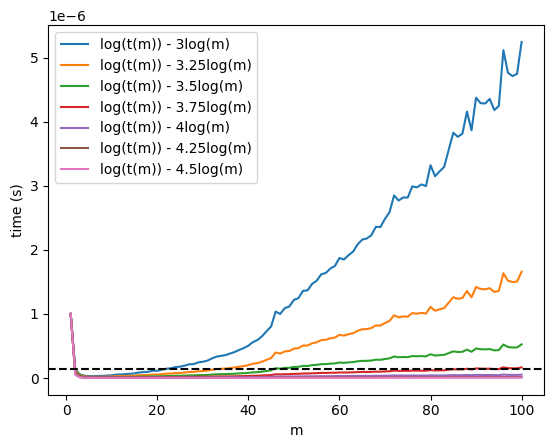

In [28]:
bench = bench_v3
m_max = bench.shape[0]

for k in (3, 3.25, 3.5, 3.75, 4, 4.25, 4.5):
    c = np.mean(bench[5:] / np.arange(5, m_max) ** k)
    print(f"t(m) = {c:.3e}m^{k} ?")
    plt.plot(range(1, m_max + 1), bench / np.arange(1, m_max + 1) ** k, label=f'log(t(m)) - {k}log(m)')
plt.axhline(bench[1] / 8, color='black', linestyle='--')
plt.ylabel('time (s)')
plt.xlabel('m')
plt.legend()

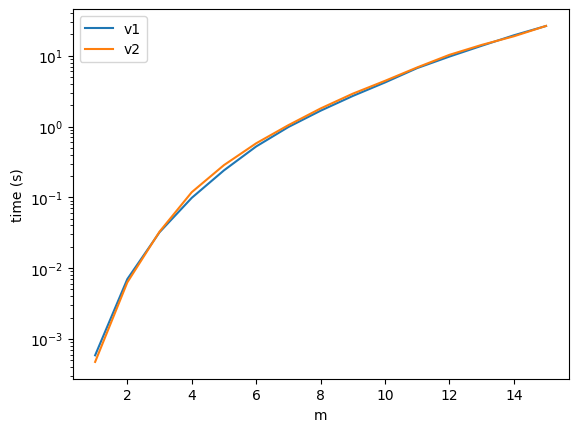

In [73]:
plt.plot(range(1, m_max + 1), bench_v1, label='v1')
plt.plot(range(1, m_max + 1), bench_v2, label='v2')
plt.ylabel('time (s)')
plt.xlabel('m')
plt.yscale('log')
plt.legend()

/tmp/ipykernel_9759/654318562.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(range(1, m_max + 1), np.log(bench_v1) / np.log(np.arange(1, m_max + 1)), label='v1')
/tmp/ipykernel_9759/654318562.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(range(1, m_max + 1), np.log(bench_v2) / np.log(np.arange(1, m_max + 1)), label='v2')


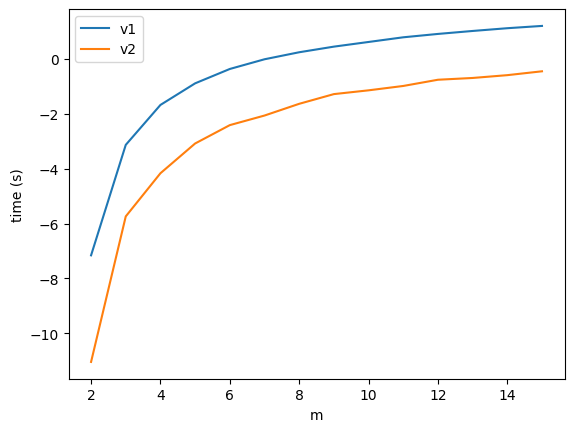

In [41]:
plt.plot(range(1, m_max + 1), np.log(bench_v1) / np.log(np.arange(1, m_max + 1)), label='v1')
plt.plot(range(1, m_max + 1), np.log(bench_v2) / np.log(np.arange(1, m_max + 1)), label='v2')
plt.ylabel('time (s)')
plt.xlabel('m')
plt.legend()

In [18]:
%%timeit
_ = compute_polynomials(10)

410 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
compute_polynomials_v2(3)

array([[[ 0.05555556,  0.61111111,  0.33333333],
        [-0.16666667, -0.16666667,  0.33333333],
        [ 0.11111111, -0.44444444,  0.33333333]],

       [[-0.05555556, -0.27777778,  0.33333333],
        [ 0.11111111,  0.55555556,  0.33333333],
        [-0.05555556, -0.27777778,  0.33333333]],

       [[ 0.11111111, -0.44444444,  0.33333333],
        [-0.16666667, -0.16666667,  0.33333333],
        [ 0.05555556,  0.61111111,  0.33333333]]])

In [37]:
m = 1
for m in tqdm(range(1, 30)):
    # u = compute_polynomials(m)
    u = compute_polynomials_v2(m)
    u_v2 = compute_polynomials_v4(m)
    for x in range(m):
        for mu in range(m):
            ok = np.max(np.abs(u_v2[mu, x] - u[mu, x])) < 1e-5
            if not ok:
                print(f"{m=}, {x=}, {mu=}")
                p = u_v2[mu, x]
                print("Old")
                print(np.round(u[mu, x], 3))
                print("New")
                print(np.round(p, 3))
                print("Diff")
                print(np.round(np.abs(u_v2[mu, x] - u[mu, x]), 3))
                print("Max diff")
                print(np.max(np.abs(u_v2[mu, x] - u[mu, x])))
                raise Exception('not ok')

  0%|          | 0/29 [00:00<?, ?it/s]

In [38]:
m = 1
for m in tqdm(range(1, 30)):
    # u = compute_polynomials(m)
    u = compute_polynomials_v2(m)
    u_v2 = compute_polynomials_v3(m)
    for x in range(m):
        for mu in range(m):
            ok = np.max(np.abs(u_v2[mu, x] - u[mu, x])) < 1e-5
            if not ok:
                print(f"{m=}, {x=}, {mu=}")
                p = u_v2[mu, x]
                print("Old")
                print(np.round(u[mu, x], 3))
                print("New")
                print(np.round(p, 3))
                print("Diff")
                print(np.round(np.abs(u_v2[mu, x] - u[mu, x]), 3))
                print("Max diff")
                print(np.max(np.abs(u_v2[mu, x] - u[mu, x])))
                raise Exception('not ok')

  0%|          | 0/29 [00:00<?, ?it/s]

In [13]:
compute_polynomials(3)

array([[[ 0.05555556,  0.61111111,  0.33333333],
        [-0.16666667, -0.16666667,  0.33333333],
        [ 0.11111111, -0.44444444,  0.33333333]],

       [[-0.05555556, -0.27777778,  0.33333333],
        [ 0.11111111,  0.55555556,  0.33333333],
        [-0.05555556, -0.27777778,  0.33333333]],

       [[ 0.11111111, -0.44444444,  0.33333333],
        [-0.16666667, -0.16666667,  0.33333333],
        [ 0.05555556,  0.61111111,  0.33333333]]])

In [6]:
def bos_data_log_likelihood(m: int, data: np.ndarray, mu: int, pi: float) -> float:
    weights = group_sum(m, data)
    liklihoods = observation_likelihood(m, mu, pi)
    liklihoods[weights == 0] = 1
    return np.sum(weights * np.log(liklihoods))

In [7]:
def gen_data(m: int, n: int, seed: int = None) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)
    
    true_mu = np.random.randint(1, m + 1)
    true_pi = np.random.rand()

    print(f'true_mu: {true_mu}, true_pi: {true_pi}')

    np.random.seed(seed)
    data = np.array([bos_model(m, true_mu, true_pi) for _ in range(n)])
    return data, true_mu, true_pi

In [8]:
def get_polynomial(m: int, mu: int) -> np.ndarray:
    """
    
    P(x | mu, pi) = sum_{i=1}^{m - 1} v(x, mu, i) * pi ** i
    
    Returns:
        v, np.ndarray of shape (m, m):
            v[i, j] = v(i, mu, j)
    """
    pi_sample = np.arange(1, m + 1) / (m + 1)
    y = np.empty((m, m))
    for i in range(m):
        y[:, i] = observation_likelihood(m, mu, pi_sample[i])
    
    v = np.empty((m, m))
    for i in range(m):
        poly = lagrange(pi_sample, y[i]).coefficients
        v[i, -poly.shape[0]:] = poly
    return v


In [9]:
get_polynomial(3, 1)

array([[ 0.05555556,  0.61111111,  0.33333333],
       [-0.16666667, -0.16666667,  0.33333333],
       [ 0.11111111, -0.44444444,  0.33333333]])

In [10]:
lagrange(np.arange(1, 5), np.arange(1, 5) ** 2).coefficients

array([-4.44089210e-16,  1.00000000e+00, -3.55271368e-15,  0.00000000e+00])

  0%|          | 0/100 [00:00<?, ?it/s]

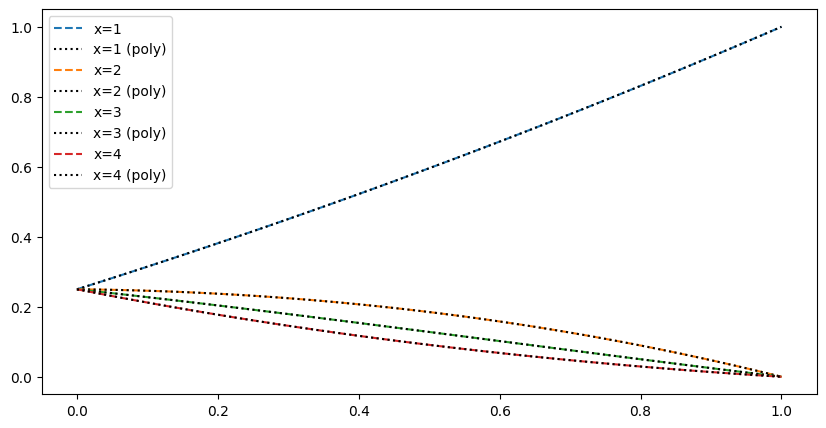

In [11]:
# plot the polynomial
m = 4
mu = 1

nb_points = 100
delta = 1e-10
pi_range = np.linspace(0 + delta, 1 - delta, nb_points)
log_likelihoods = np.zeros((m, nb_points))
for i in tqdm(range(nb_points)):
    log_likelihoods[:, i] = observation_likelihood(m, mu, pi_range[i])

polynomial = get_polynomial(m, mu)

plt.figure(figsize=(10, 5))
for i in range(m):
    prev = plt.plot(pi_range, log_likelihoods[i, :], label=f'x={i + 1}', linestyle='--')
    # plt.plot(pi_range, np.polyval(polynomial[i, :], pi_range), linestyle=':', label=f'x={i + 1} (poly)', color=prev[0].get_color())
    plt.plot(pi_range, np.polyval(polynomial[i, :], pi_range), linestyle=':', label=f'x={i + 1} (poly)', color='black')
plt.legend()

In [14]:
np.polyval(polynomial[1, :], 1/3)

0.21913580246913605

true_mu: 2, true_pi: 0.781966975946223


  0%|          | 0/100 [00:00<?, ?it/s]

mu = 2,	 pi = 0.78
best mu = 2,	 best pi = 0.77


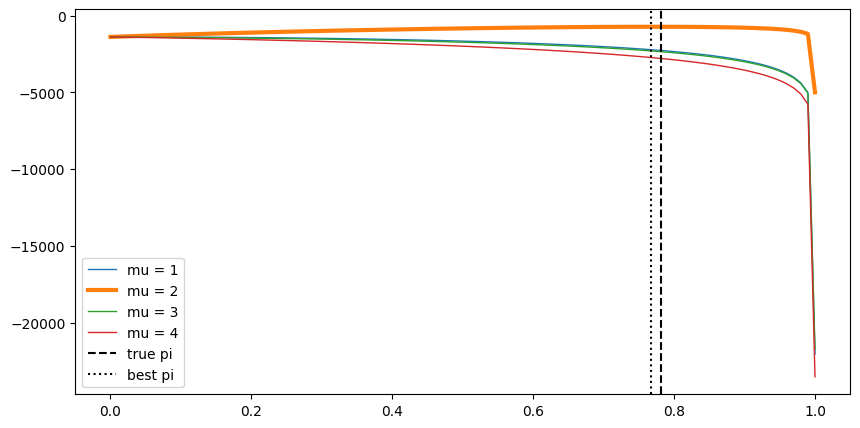

In [9]:
# gen data
seed = 629
n = 1_000
m = 4

data, true_mu, true_pi = gen_data(m, n, seed)

nb_points = 100
delta = 1e-10
pi_range = np.linspace(0 + delta, 1 - delta, nb_points)
log_likelihoods = np.zeros((m, nb_points))
for i in tqdm(range(nb_points)):
    for j in range(m):
        log_likelihoods[j, i] = bos_data_log_likelihood(m, data, j + 1, pi_range[i])

best_mu = np.argmax(log_likelihoods.max(axis=1)) + 1
best_pi = pi_range[np.argmax(log_likelihoods.max(axis=0))]
print(f"mu = {true_mu},\t pi = {true_pi:.2f}")
print(f"best mu = {best_mu},\t best pi = {best_pi:.2f}")

if best_mu != true_mu:
    print('WARNING: best mu is not true mu')


plt.figure(figsize=(10, 5))
for i in range(m):
    plt.plot(pi_range, log_likelihoods[i, :], label=f'mu = {i + 1}', linewidth=3 if i + 1 == true_mu else 1)

plt.axvline(true_pi, color='black', linestyle='--', label='true pi')
plt.axvline(best_pi, color='black', linestyle=':', label='best pi')
plt.legend()

In [10]:
epsilon = 1e-6
2 * (log(epsilon, 2) + 1) / (1 - log(3, 2))

64.72746046450796

In [11]:
1 / 1e-3

1000.0

In [12]:
#Univariate
n = 1000
m = 5
n_iter = 100
eps = 1e-6

seed = np.random.randint(0, 1000)
print(f'seed: {seed}')
data, true_mu, true_pi = gen_data(m, n, seed)


univariate_em(m, data, n_iter=n_iter, eps=eps)

seed: 651
true_mu: 4, true_pi: 0.7505895270970079
EM algorithm for 1 converged after 69 iterations
EM algorithm for 2 converged after 100 iterations
EM algorithm for 3 converged after 100 iterations
EM algorithm for 4 converged after 40 iterations
EM algorithm for 5 converged after 100 iterations


(4,
 0.7641694455508141,
 -850.954463240598,
 array([0.02952353, 0.04936358, 0.08531473, 0.7660858 , 0.06971237]))

In [6]:
def compute_ll(m, data, mu, pi):
    s = 0
    for x in data:
        s += np.log(_probability_x_given_mu_pi(m, x, mu, pi))
    return s

In [7]:
#Univariate
n = 100
m = 2
seed = 0


data, true_mu, true_pi = gen_data(m, n, seed)

true_mu: 1, true_pi: 0.5928446182250183


In [ ]:
eps = 1e-3
print("True mu: {}, True pi: {}".format(true_mu, true_pi))
mu, pi, ll, _ = univariate_em(m=m, data=data, eps=eps)

print(
    "Estimated mu: {}, Estimated pi: {}, LL: {} ".format(
        mu, pi, ll
    )
)
print("Indepentent LL: {}".format(compute_ll(m, data, mu, pi)))
print("True LL: {}".format(compute_ll(m, data, true_mu, true_pi)))

True mu: 3, True pi: 0.7955347461391471
EM algorithm for 1 converged after 30 iterations
EM algorithm for 2 converged after 56 iterations
EM algorithm for 3 converged after 18 iterations
EM algorithm for 4 converged after 49 iterations
Estimated mu: 3, Estimated pi: 0.7889801558710181, LL: -68.02711866951702 
Indepentent LL: -68.02668453582108
True LL: -68.03263564329843


In [ ]:
#Univariate
m = 4
eps = 1e-10


print("True mu: {}, True pi: {}".format(true_mu, true_pi))
mu, pi, ll, _ = estimate_mu_pi_bos(m=m, data=data, epsilon=eps)

print(
    "Estimated mu: {}, Estimated pi: {}, LL: {} ".format(
        mu, pi, ll
    )
)
print("Indepentent LL: {}".format(compute_ll(m, data, mu, pi)))
print("True LL: {}".format(compute_ll(m, data, true_mu, true_pi)))

True mu: 3, True pi: 0.7955347461391471
Estimated mu: 3, Estimated pi: 0.790420090140681, LL: -68.02618236086607 
Indepentent LL: -68.02618236086613
True LL: -68.03263564329843


In [221]:
m = 4
x = 3
mu = 2
pi = 0.9

print(_probability_x_given_mu_pi(m, x, mu, pi))

0.03925


In [223]:
aux_probability_x_given_mu_pi(1, m + 1, m, x, mu, pi)

0.03924999999999999

In [141]:
mu = 2
pi = 0.9

In [142]:
x = 1
_probability_x_given_mu_pi(m=2, x=x, mu=mu, pi=pi), pi * (mu <= x) + (1 - pi)  / 2

(0.04999999999999999, 0.04999999999999999)

In [143]:
x = 2
_probability_x_given_mu_pi(m=2, x=x, mu=mu, pi=pi), pi * (mu > x - 1) + (1 - pi)  / 2

(0.95, 0.95)

In [217]:
def loc_aux_probability_x_given_mu_pi(lower: int, 
                                  upper: int,
                                  m: int, 
                                  x: int, 
                                  mu: int, 
                                  pi: float,
                                  depth: int = 0
                                  ) -> float:
    """
    If e_i = [[ lower, upper[[ is the first interval of the trajectory
    compute P(x, e_i | mu, pi) = sum_{e_2, ..., e_{m-1}} P(e_1, ..., e_{m-1}, x | mu, pi)
    = sum_{e_2, ..., e_{m-1}} prod_{i=1}^{m-1} P(e_{i+1} | e_i, mu, pi)
    = sum_{e_2} P(e_2 | e_1, mu, pi) sum_{e_3, ..., e_{m-1}} prod_{i=2}^{m-1} P(e_{i+1} | e_i, mu, pi)
    = sum_{e_2} P(e_2 | e_1, x, mu, pi) P(x, e_2, mu, pi)
    """
    # if lower + 1 == upper:
    #     return 1
    print('    ' * depth + '-' * 20)
    print(f"{'    ' * depth}{lower=}, {upper=}")
    s = 0
    p_e_min = 0
    for y in range(lower, x):
        good_choice = mu > y
        # if upper == x + 1:
        #     good_choice = good_choice or (mu == x)
        print(f"{'    ' * depth}y={y} (e_+)")
        print(f"{'    ' * depth}  good_choice={good_choice}")
        py = (pi * good_choice + (1 - pi) * (upper - y - 1) / (upper - lower)) \
            * loc_aux_probability_x_given_mu_pi(y + 1, upper, m, x, mu, pi, depth=depth + 1)
        print(f"{'    ' * depth}  {py=:.2f}")
        p_e_min += py
    # print(f"{'    ' * depth}p_e_min={p_e_min}")
    print(f"{'    ' * depth}y={x} (e_=)")
    good_choice = mu == x
    if lower == x:  # e_- = e_=
        good_choice = good_choice or (mu <= x)
    if upper == x + 1:  # e_+ = e_=
        good_choice = good_choice or (mu >= x)
    print(f"{'    ' * depth}  {good_choice=}")
    p_e_eq = pi * good_choice + (1 - pi)  / (upper - lower)
    print(f"{'    ' * depth}  py={p_e_eq:.2f}")
    p_e_max = 0
    for y in range(x + 1, upper):
        print(f"{'    ' * depth}y={y} (e_-)")
        print(f"{'    ' * depth}  good_choice={mu < y}")
        py = (pi * (mu < y) + (1 - pi) * (y - lower) / (upper - lower)) \
            * loc_aux_probability_x_given_mu_pi(lower, y, m, x, mu, pi, depth=depth + 1)
        p_e_max += py
        print(f"{'    ' * depth}  {py=:.2f}")
    # print(f"{'    ' * depth}p_e_max={p_e_max}")
    s = p_e_min + p_e_eq + p_e_max
    print(f"{'    ' * depth}p_tot={s  / (upper - lower):.2f}")
    print('    ' * depth + '-' * 20)
    return s  / (upper - lower)


In [218]:
mu = 1

In [219]:
x = 1
print(f"mu={mu}, x={x}")
print(f"Expected: {pi * (mu <= x) + (1 - pi)  / 2}")
loc_aux_probability_x_given_mu_pi(1, 3, m=2, x=x, mu=mu, pi=pi)

mu=1, x=1
Expected: 0.95
--------------------
lower=1, upper=3
y=1 (e_=)
  good_choice=True
  py=0.95
y=2 (e_-)
  good_choice=True
    --------------------
    lower=1, upper=2
    y=1 (e_=)
      good_choice=True
      py=1.00
    p_tot=1.00
    --------------------
  py=0.95
p_tot=0.95
--------------------


0.95

In [220]:
x = 2
print(f"mu={mu}, x={x}")
print(f"Expected: {pi * (mu > x - 1) + (1 - pi)  / 2:.2f}")
loc_aux_probability_x_given_mu_pi(1, 3, m=2, x=x, mu=mu, pi=pi)

mu=1, x=2
Expected: 0.05
--------------------
lower=1, upper=3
y=1 (e_+)
  good_choice=False
    --------------------
    lower=2, upper=3
    y=2 (e_=)
      good_choice=True
      py=1.00
    p_tot=1.00
    --------------------
  py=0.05
y=2 (e_=)
  good_choice=False
  py=0.05
p_tot=0.05
--------------------


0.04999999999999999